Lidan Avisar

# Overview
### Due Dec 14th

##Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in individually, you can collaborate with one classmate but EACH must turn in a copy of the homework.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook. Please leave the audio loaded when submitting the homework.

YOU MUST SUBMIT EACH HOMEWORK, even if your partner submits! Upload your completed assignment on moodle.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
from matplotlib import rcParams
import scipy
import os
import sys
import glob
import pickle
from music21 import converter, instrument, note, chord, stream
import torch

# PCA with a Linear Autoencoder


In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in TensorFlow (essentially Keras with an expanded toolset); the functions we call are nearly identical to those you will see in Keras.

Let's create a sin+noise signal to use as input to our network:

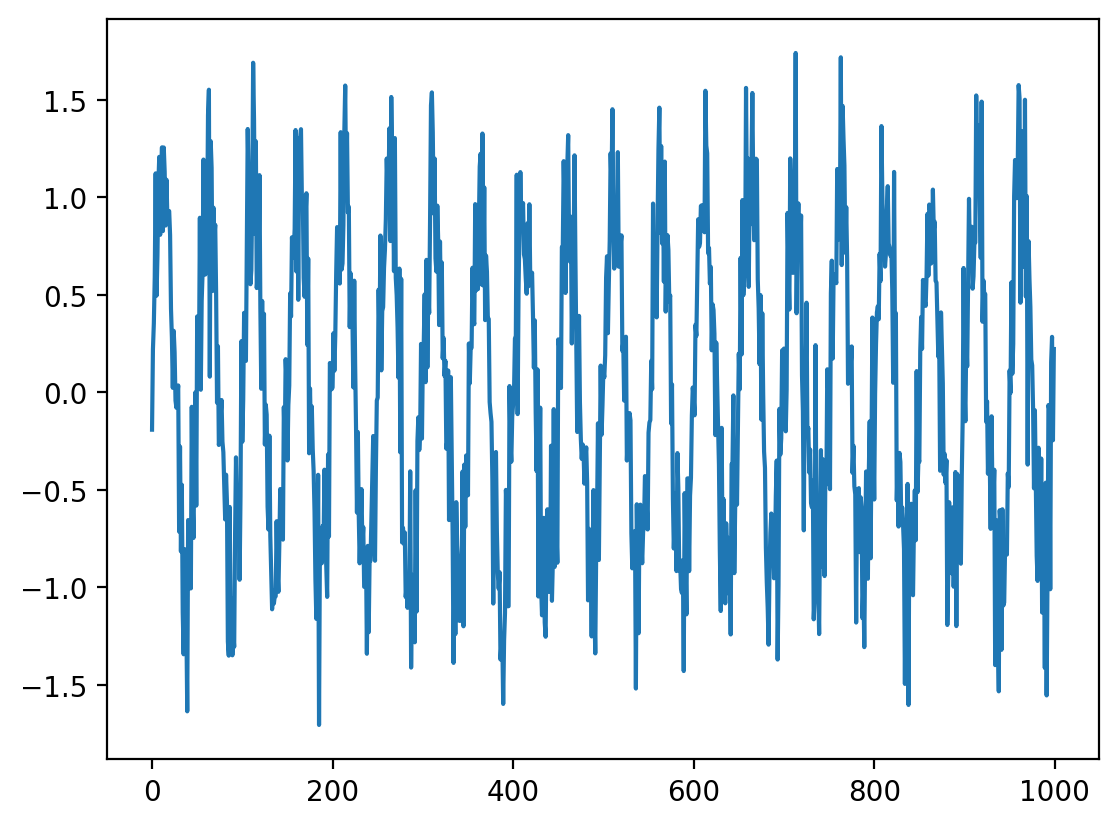

In [ ]:
f0 = 200
fs = 10000
T = 3
Ns = fs*T

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers.

This neural network is implemented in TensorFlow.

Please review the code cells below, and answer the questions that follow.

In [ ]:
# Initialize parameters
n_inputs = xmat.shape[0]
n_hidden = 2
learning_rate = 0.01
n_iterations = 10000

# Convert data to PyTorch tensors
X_train = torch.tensor(xmat.T, dtype=torch.float32)
X_test = X_train.clone()

# Initialize weights
W = torch.empty(n_inputs, n_hidden, dtype=torch.float32, requires_grad=True)
torch.nn.init.trunc_normal_(W, std=0.1)

# Training loop
optimizer = torch.optim.Adam([W], lr=learning_rate)


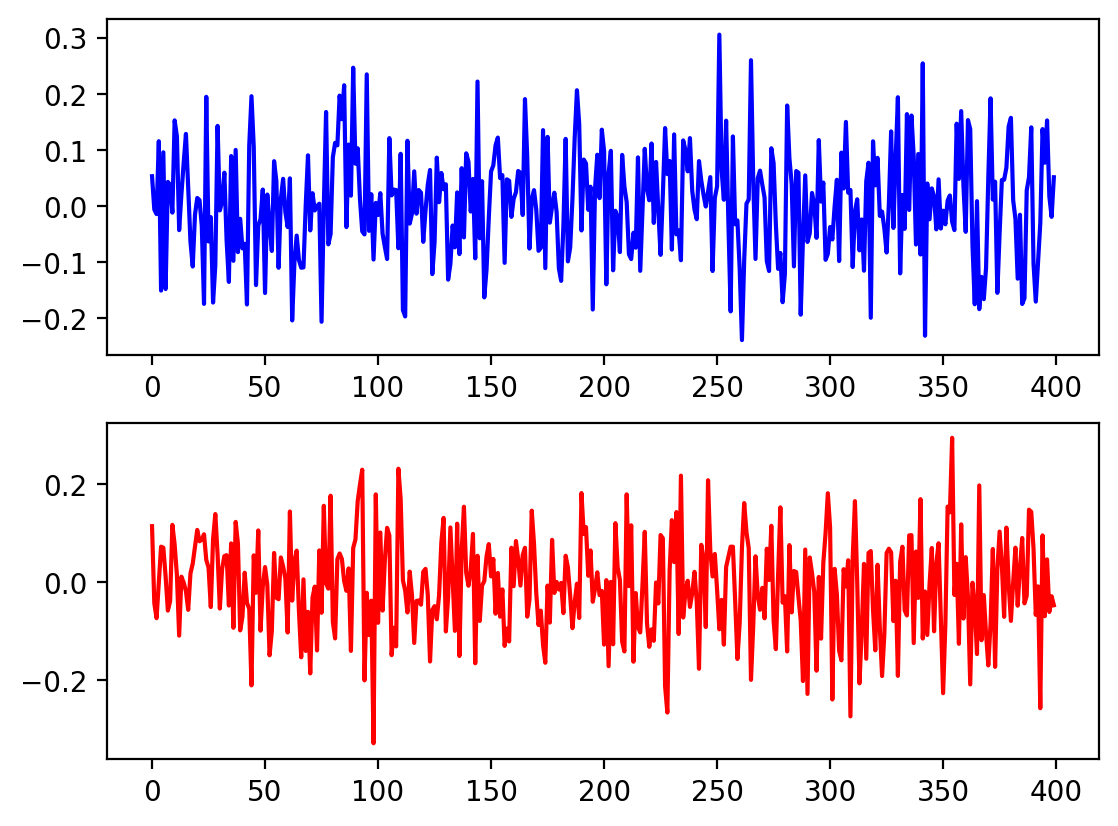

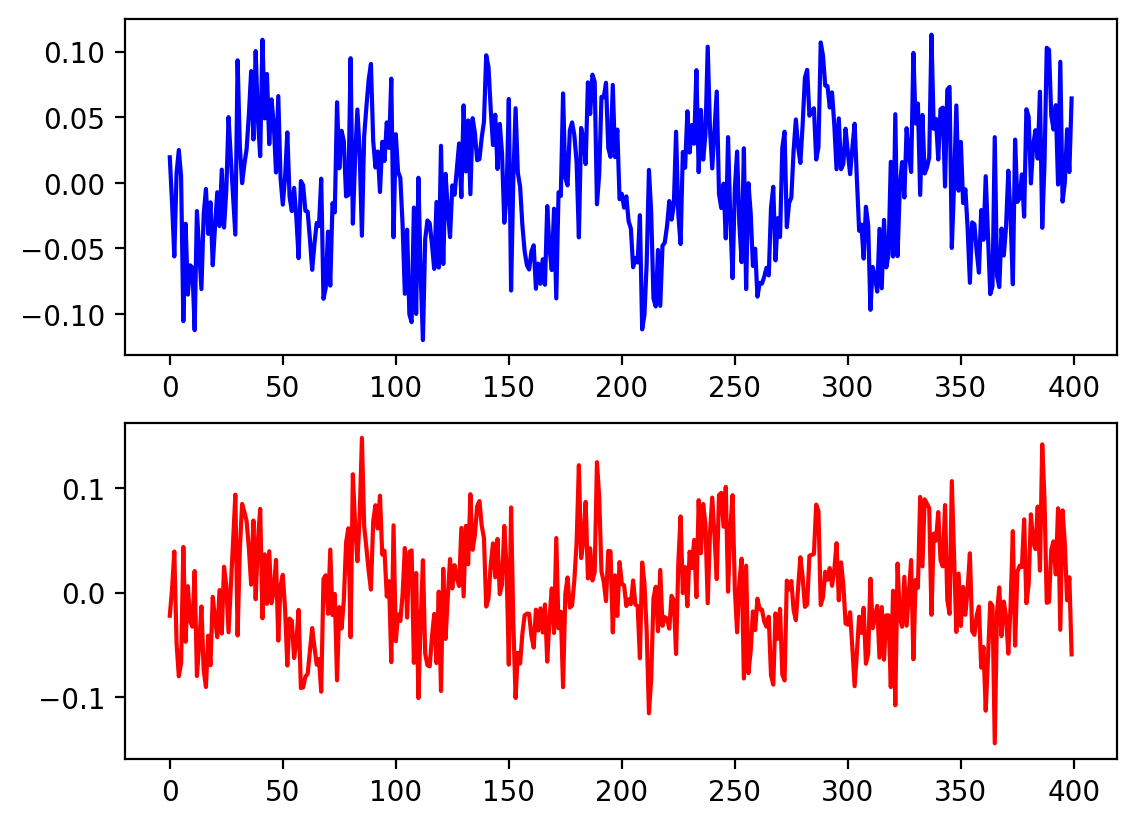

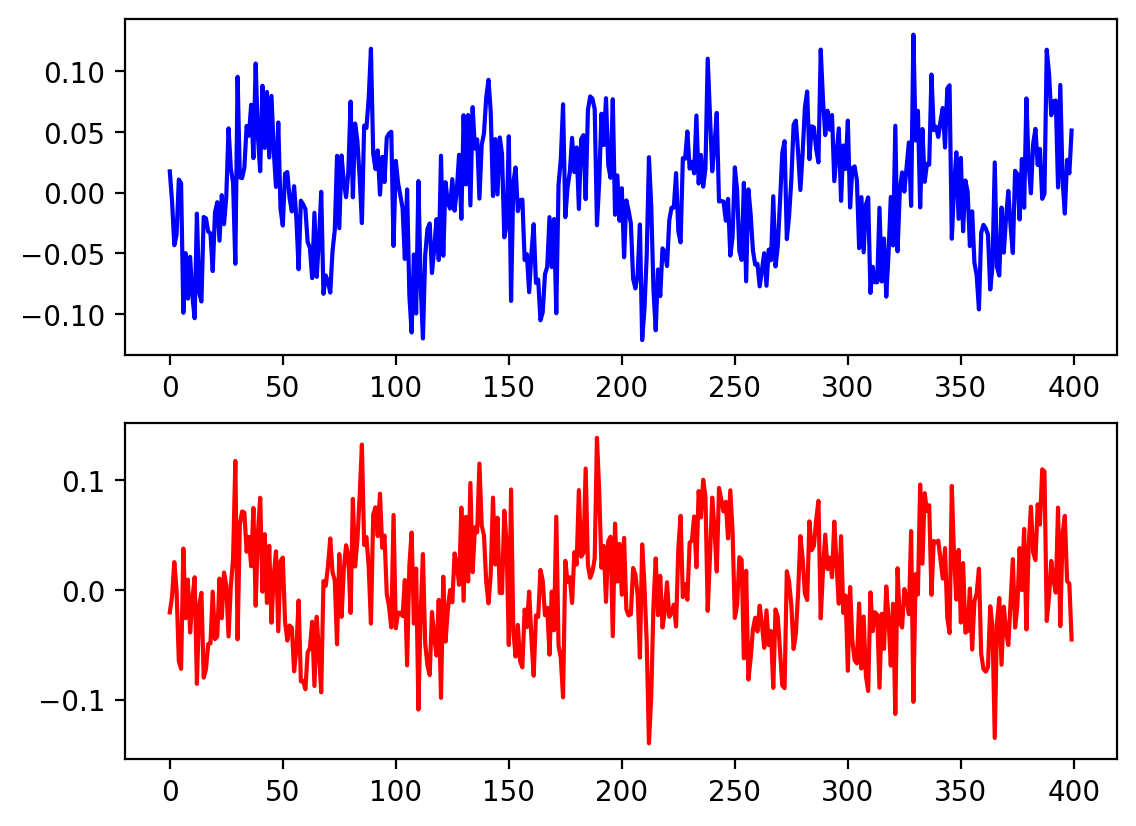

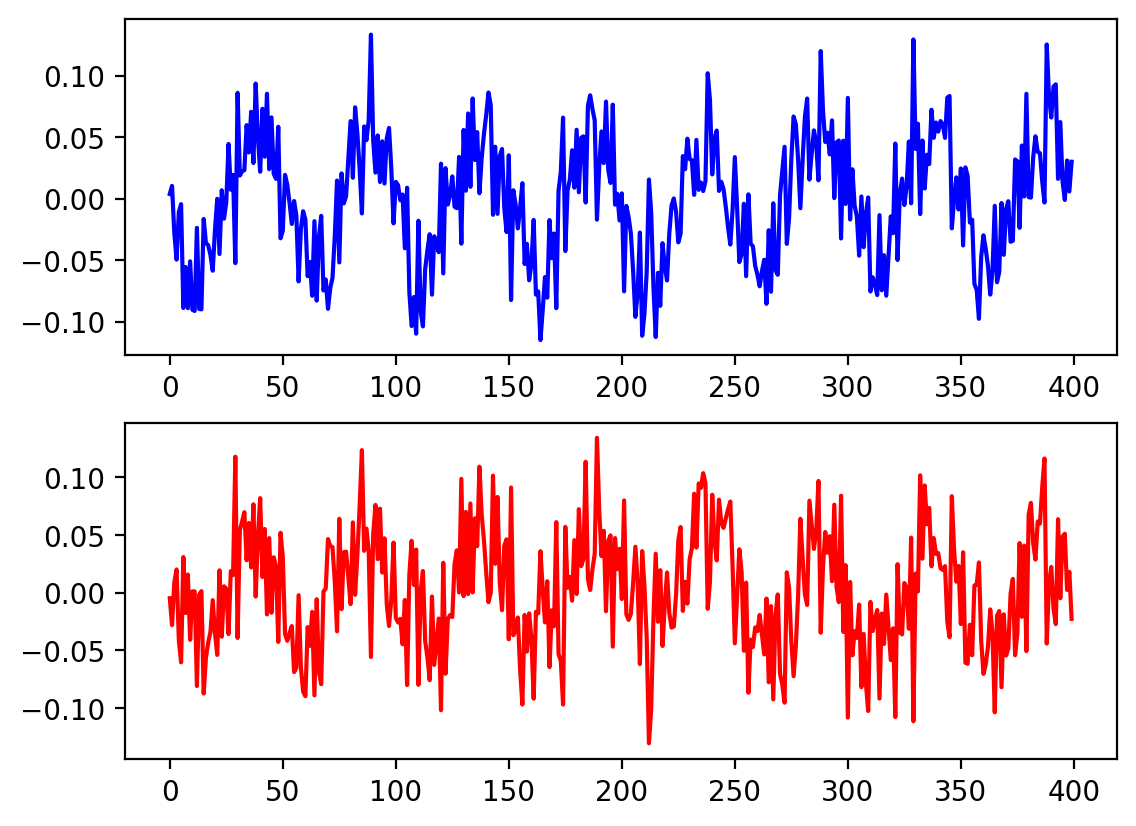

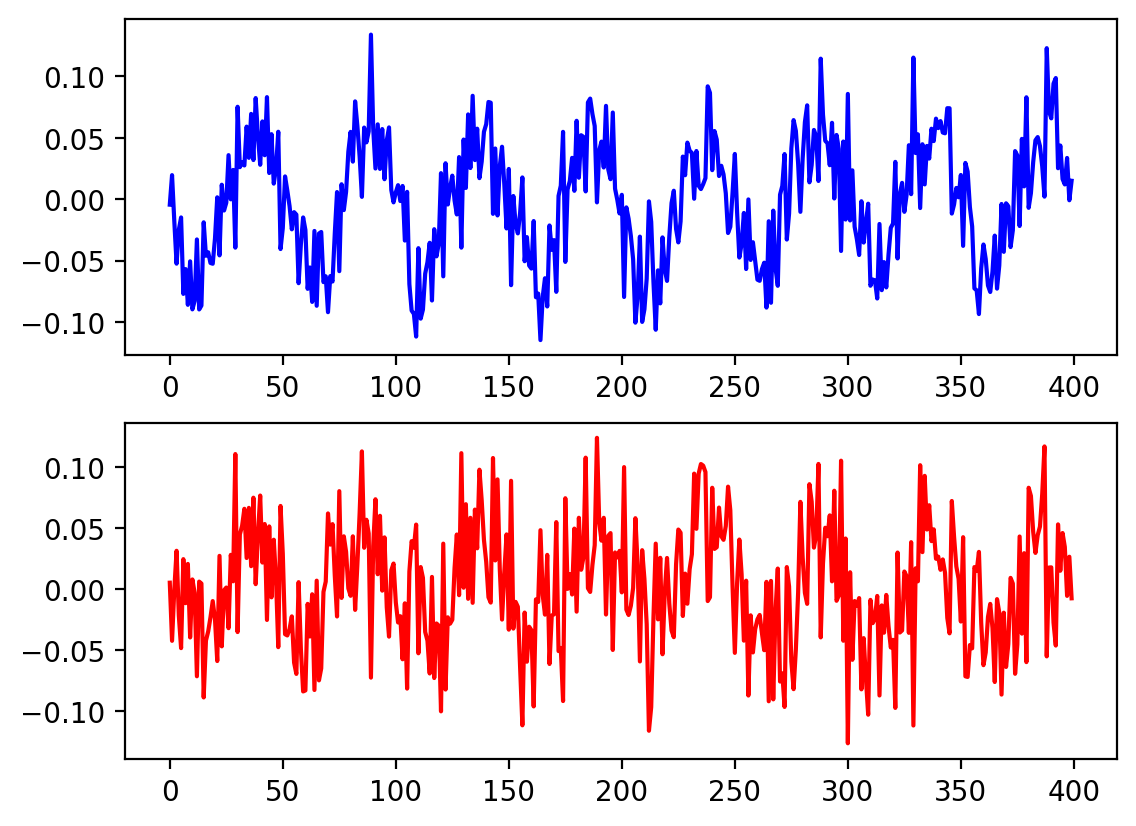

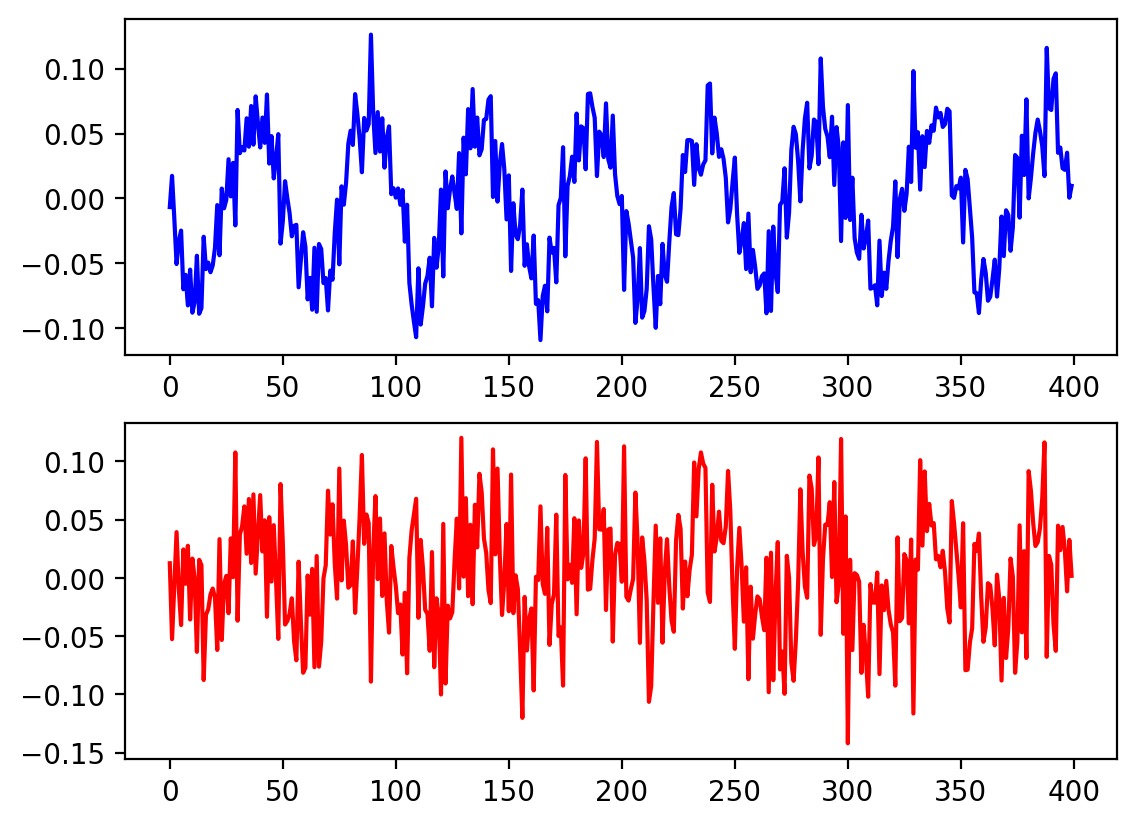

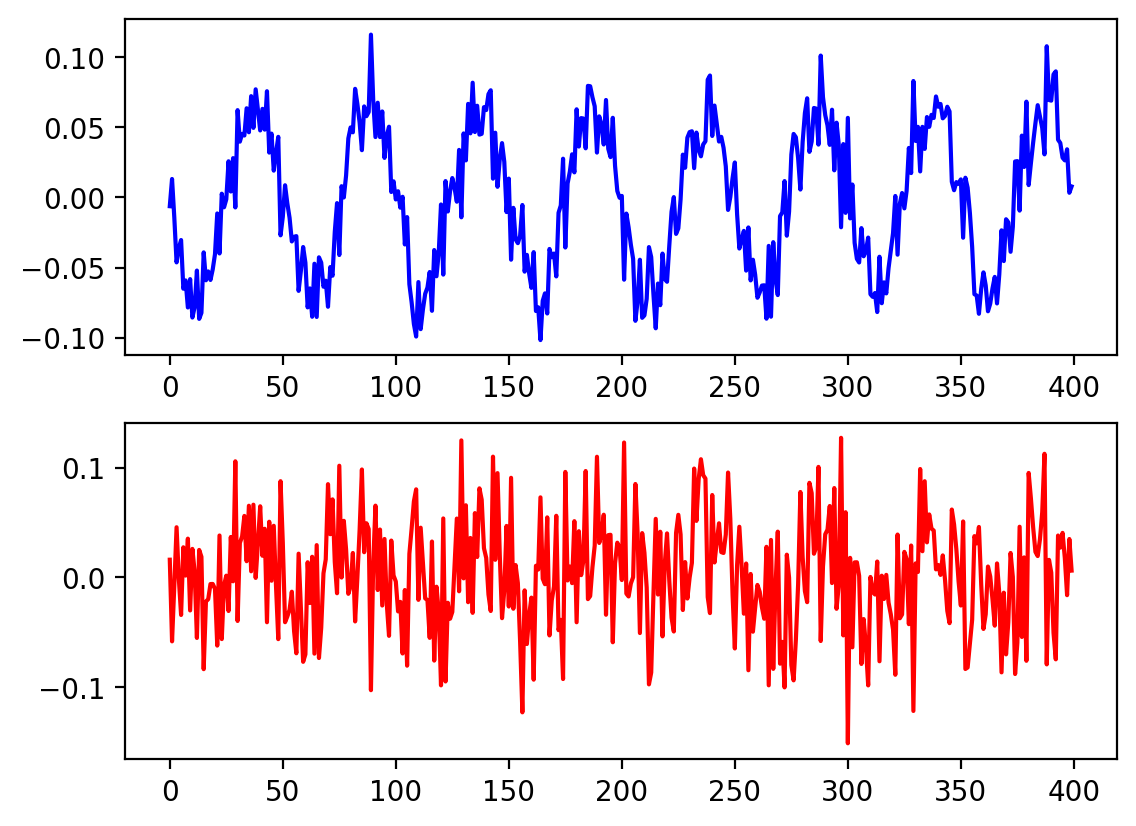

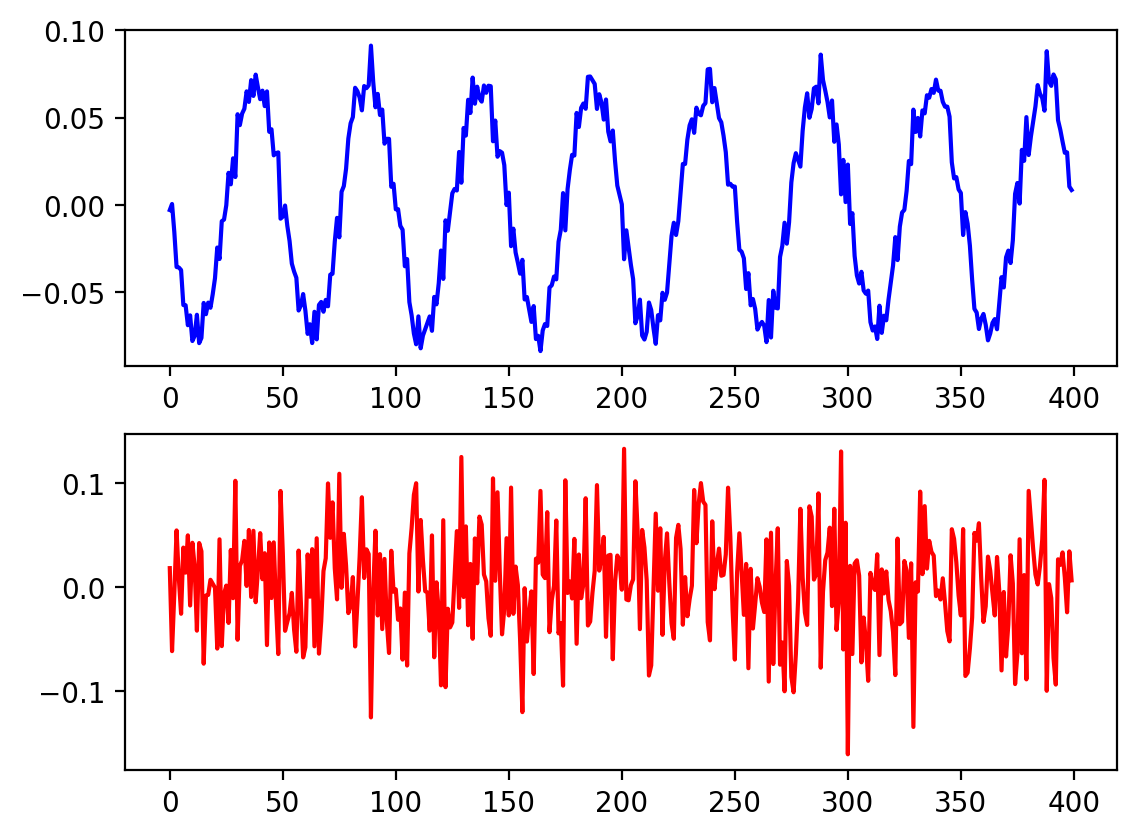

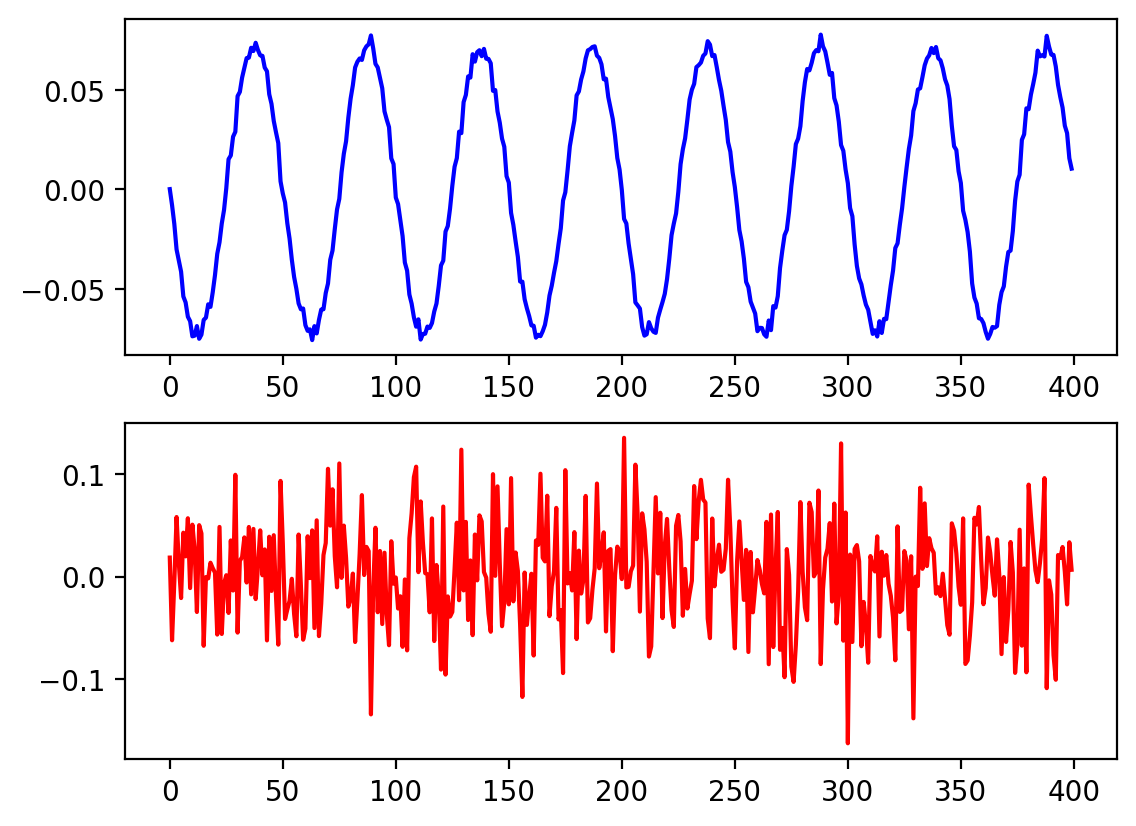

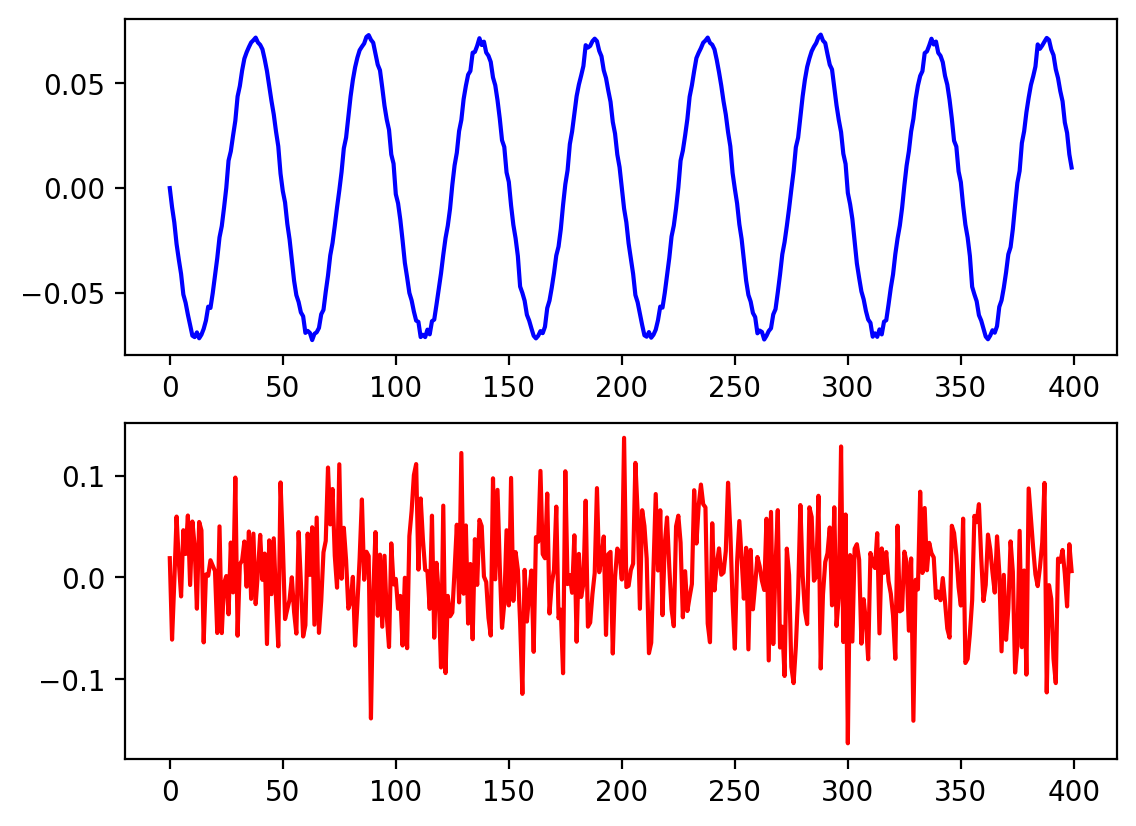

Done with training


In [ ]:
col = ['b', 'r', 'g', 'c', 'm', 'y', 'k']

for iteration in range(n_iterations):
    # Forward pass
    hidden = torch.matmul(X_train, W)
    outputs = torch.matmul(hidden, W.T)
    reconstruction_loss = torch.mean((outputs - X_train) ** 2)

    # Backward pass
    optimizer.zero_grad()
    reconstruction_loss.backward()
    optimizer.step()

    # Visualization every 1000 iterations
    if iteration % 1000 == 0:
        with torch.no_grad():
            W_val = W.detach().numpy()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden, 1, k + 1)
            plt.plot(W_val[:, k], col[k % len(col)])
        plt.show(block=False)
        plt.pause(0.001)

# Get codings
with torch.no_grad():
    codings_val = torch.matmul(X_test, W).numpy()

print("Done with training")


##### Question 1 (10 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

An autoencoder is a type of neural network designed to learn efficient representations of input data by compressing it into a lower-dimensional space (encoding) and then reconstructing the original input from this compressed representation (decoding).

It consists of two main components:
1. **Encoder**: Maps the input to a reduced-dimensional space.
2. **Decoder**: Reconstructs the input from this space.

The goal of training an autoencoder is to minimize the reconstruction error, ensuring the output is as similar as possible to the input.

**Ideally, when a portion of signal \(x\) is passed through the trained network:**

1. The **encoder** would extract and retain the most essential features of the signal while discarding noise or less relevant details.
2. The **decoder** would then use these extracted features to reconstruct the original signal with minimal loss or distortion.

As a result, the output signal should closely resemble the input signal, preserving its key characteristics.

##### Question 2 (10 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

For a single forward pass, the input layer receives one row of the matrix X_train, which is derived from the buffered signal X. Each row represents a window of 400 consecutive samples, as defined by the `buffer` function with `window_size=400` and `hop_size=200`. This means X_train has a shape of (N, 400), where N is the total number of overlapping windows.

Each row passed to the network contains the raw amplitude values of a specific window. This enables the encoder to extract features from these 400 samples and the decoder to reconstruct the original 400 samples. The overlapping structure (due to the hop size of 200) ensures continuity between frames and allows the network to retain both unique and shared characteristics of the signal across segments.


##### Question 3 (10 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

The network weights are represented by the variable `W`. This is a PyTorch tensor initialized as a matrix with dimensions `(n_inputs, n_hidden)`, where `n_inputs` corresponds to the size of each input vector (400 in this case) and `n_hidden` is the number of layers in the hidden layer (2 in this case).

Before training, the weights are initialized using the `torch.nn.init.trunc_normal_` function. This method assigns values to `W` from a truncated normal distribution with a standard deviation of 0.1. The truncated normal initialization ensures that the weights are close to zero but not exactly zero, which helps the network converge more effectively during training. Additionally, the `requires_grad=True` attribute is set, enabling the weights to be updated during backpropagation.


##### Question  4 (10 points)

What is being minimized in the reconstruction loss? Why is this helpful?

The reconstruction loss minimizes the **mean squared error (MSE)** between the original input (`X_train`) and the reconstructed output (`outputs`) produced by the network.

Here, \( N \) is the total number of elements in the input. The goal of minimizing this loss is to reduce the difference between the original input and the reconstructed output, ensuring that the network efficiently captures the key features of the input in the compressed space.

Minimizing the reconstruction loss is helpful because it forces the network to focus on the most important features of the input while filtering out noise. By achieving a low reconstruction loss, the autoencoder ensures that the compressed representation retains the critical characteristics of the data, enabling efficient compression and accurate reconstruction.

Once the autoencoder has learned to produce high-quality reconstructions with a low MSE, its compressed representations can be used as inputs for various downstream tasks. For example, they can serve as effective feature vectors in classification or regression models, where removing noise and focusing on essential information can significantly improve model performance.

##### Question 5 (10 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training?

An optimizer is an algorithm that adjusts the model's parameters, such as weights and biases, to minimize the loss function, which measures how far the model's predictions are from the actual values. During training, the optimizer uses gradients, which represent the direction and magnitude of changes needed to reduce the loss, calculated through backpropagation. The optimizer takes these gradients and decides how much to adjust each parameter to improve the model’s performance. It balances the step size (learning rate) and the direction of movement to ensure the model learns efficiently without overshooting or getting stuck in suboptimal solutions. More advanced optimizers, adapt the learning rate dynamically for each parameter based on the history of gradients, which helps accelerate convergence and improve stability. the goal of the optimizer is to guide the model towards an optimal state where it performs accurately on both training and unseen data. A poor choice of optimizer can result in a suboptimal solution or slow convergence.


$\textbf{Stochastic Gradient Descent (SGD)}:$

Stochastic Gradient Descent (SGD) is an optimization algorithm that updates model parameters using gradients calculated from a single data point or small subset (mini-batch) rather than the entire dataset. This makes it faster and more efficient for large datasets but introduces noise, causing an erratic path toward the optimal solution.

$\textbf{Adagrad (Adaptive Gradient Algorithm)}:$

Adagrad is an optimization algorithm that adjusts the learning rate for each parameter based on the historical accumulation of squared gradients. Parameters with larger past gradients receive smaller learning rates, while those with smaller gradients receive larger updates. This feature makes Adagrad particularly useful for sparse data problems, as it adapts well to infrequent features. However, its learning rate tends to decay over time, which can slow down training in later stages.

$\textbf{Adam (Adaptive Moment Estimation)}$:

Adam is a gradient-based optimization algorithm that combines the benefits of two techniques: momentum and adaptive learning rates. Momentum helps accelerate gradient descent by smoothing updates; it does so by using a moving average of past gradients, allowing the optimizer to build speed in consistent directions and reduce oscillations. Adam's adaptive learning rates differ from those of Adagrad by using a moving average of squared gradients rather than a cumulative sum. This prevents the learning rate from decaying too aggressively, as in Adagrad, ensuring that the optimizer maintains steady progress throughout training. By leveraging these techniques, Adam adapts the learning rate for each parameter dynamically based on the magnitude of its past gradients, ensuring larger updates for less sensitive parameters and smaller updates for frequently updated ones. This combination of momentum and adaptive learning rates allows Adam to perform efficient and stable updates, converging faster and more reliably compared to SGD, making it widely used for training deep learning models.


the optimiser used in the code is adam.
we can see this in the line:
optimizer = torch.optim.Adam([W], lr=learning_rate)








We can examine now the "codings", i.e. the hidden unit values and their distribution. The more significant codings should have smaller variances.

mean:  [-14.044436    0.0266063]
variance [0.29820132 0.77839136]


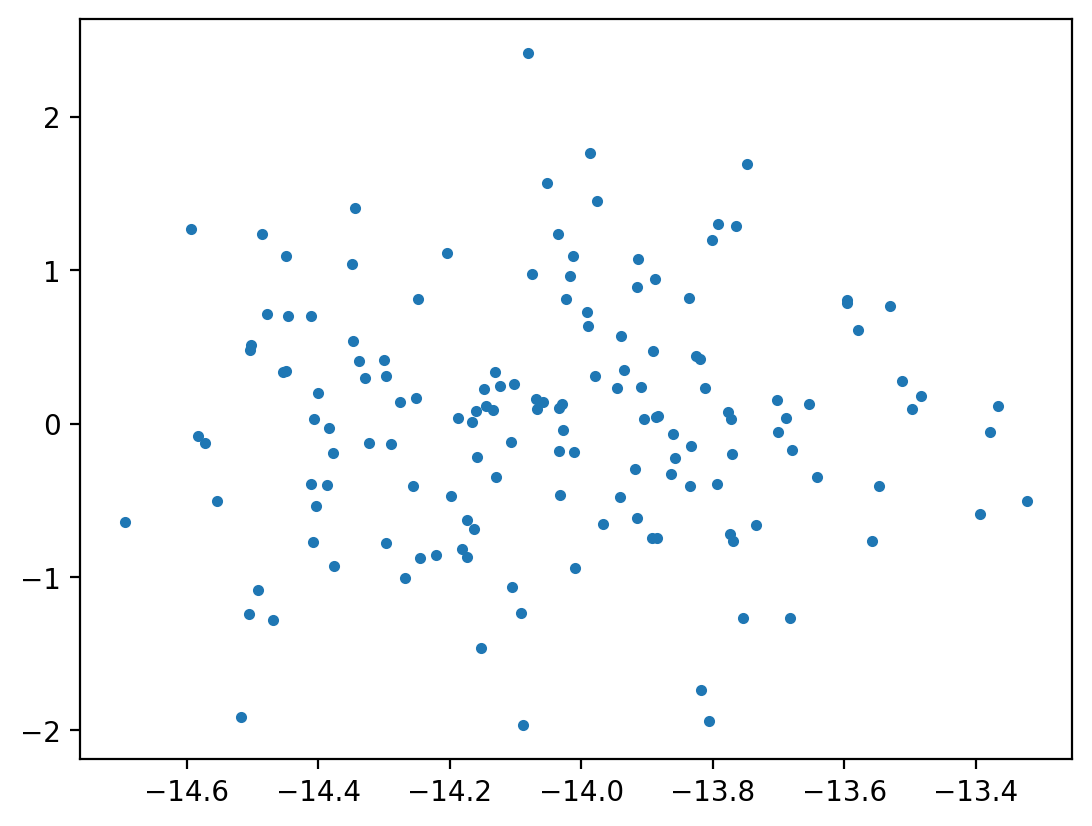

In [ ]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))

###### Question 6 (10 points)

In what way does the autoencoder network function similarly to PCA?

A linear autoencoder reduces to an implicit factorization of the data’s covariance structure, just like PCA. PCA explicitly diagonalizes the covariance matrix to identify the principal components—orthonormal directions capturing maximal variance—while a linear autoencoder learns a set of linear weights that minimize reconstruction error. Both methods yield similar subspaces because minimizing reconstruction error in a linear setting is equivalent to finding the directions of largest variance.

The linear autoencoder’s encoder weights asymptotically converge to the eigenvectors of the data’s covariance matrix, and its decoder weights align with their transposed counterparts, reconstructing the data from this reduced set of orthogonal directions. This equivalence emerges because training a linear autoencoder to minimize mean squared reconstruction error essentially solves the same optimization problem as PCA: it attempts to compress data into a low-dimensional code that discards directions of low variance and preserves directions of high variance. As a result, the latent representations learned by a properly trained linear autoencoder are similar to the principal component scores produced by PCA, and the encoder matrix converges to the same results.


##### Question 7 - PCA versus AE (20 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network?


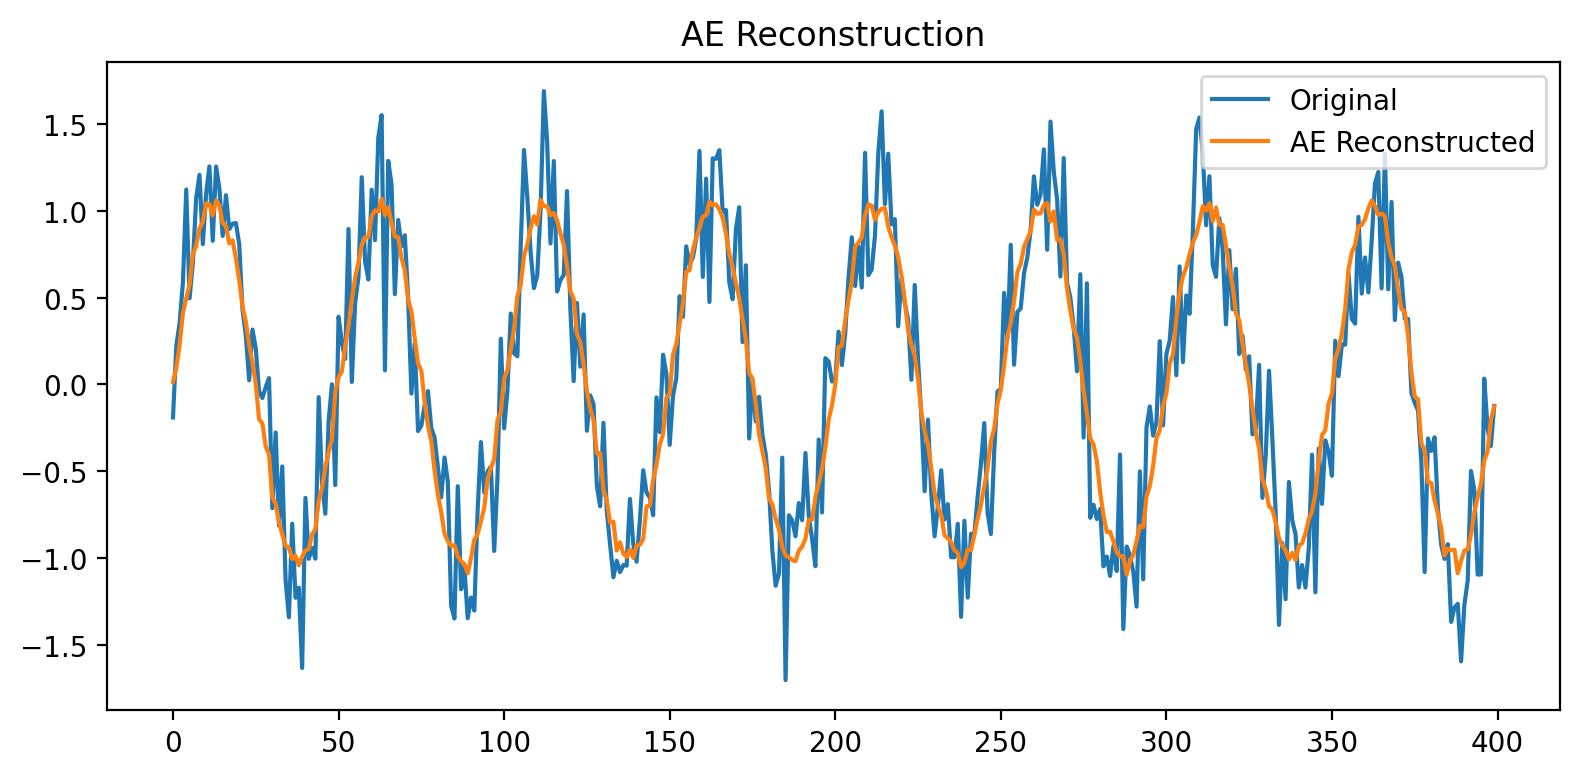

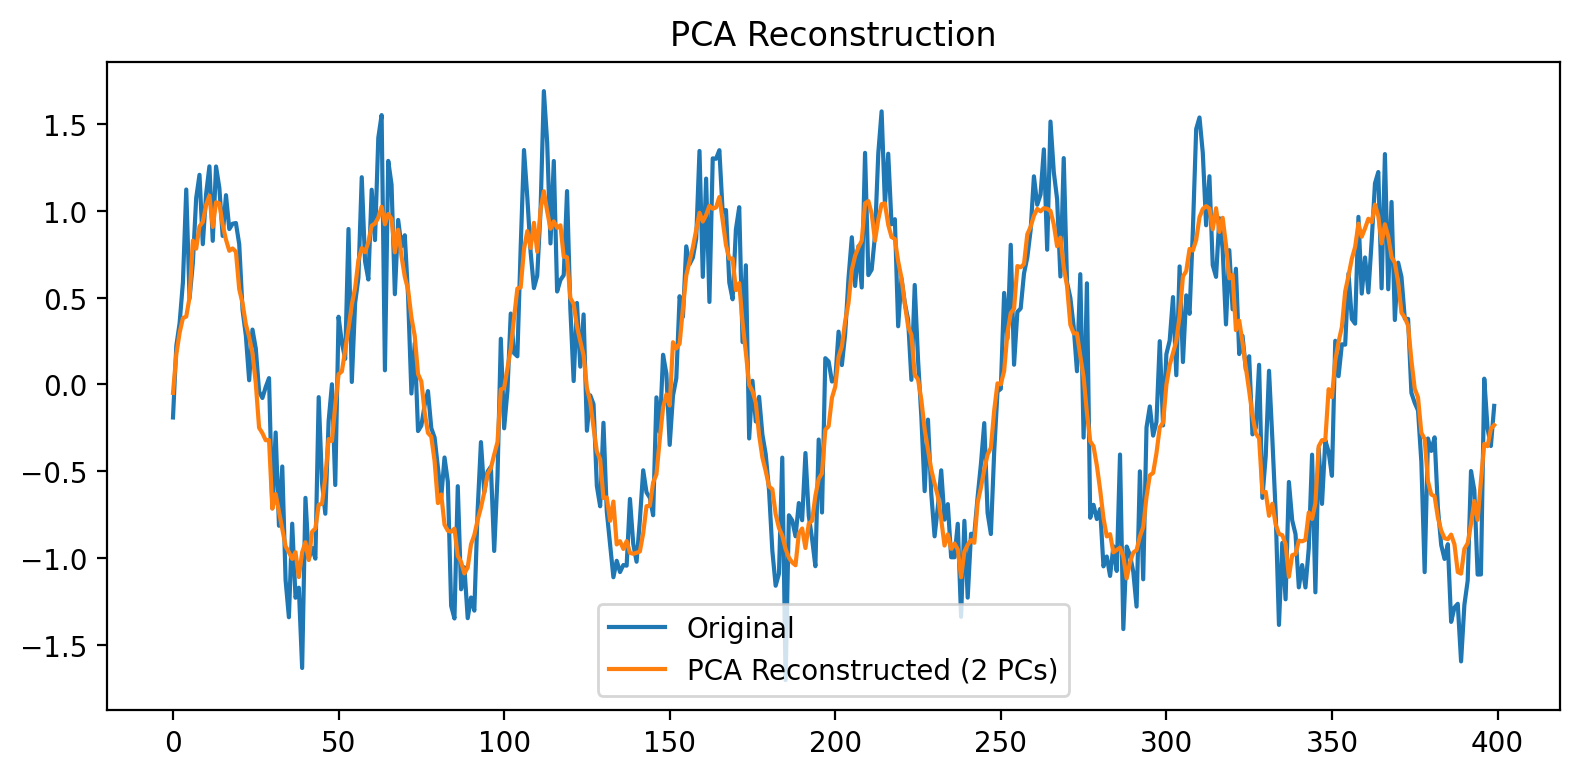

**2** principal components are needed to match the AE performance.
AE Reconstruction Error (MSE): **0.083325**
PCA Reconstruction Error (MSE, 2 components): **0.081200**


In [ ]:
from sklearn.decomposition import PCA

# Get a single sample for demonstration
# Get a single sample for demonstration
with torch.no_grad():
    sample_idx = 0
    X_sample = X_test[sample_idx:sample_idx+1]
    hidden_sample = torch.matmul(X_sample, W)
    ae_recon = torch.matmul(hidden_sample, W.T).detach().numpy().flatten()

# Plot AE reconstruction vs original in the first figure
plt.figure(figsize=(8, 4))
plt.title("AE Reconstruction")
plt.plot(X_sample[0].numpy(), label="Original")
plt.plot(ae_recon, label="AE Reconstructed")
plt.legend()
plt.tight_layout()
plt.show()

# Perform PCA with same number of components as AE
n_components = n_hidden
pca = PCA(n_components=n_components)
pca.fit(X_train.detach().numpy())
X_transformed = pca.transform(X_sample.detach().numpy())
pca_recon = pca.inverse_transform(X_transformed).flatten()

# Plot PCA reconstruction vs original in the second figure
plt.figure(figsize=(8, 4))
plt.title("PCA Reconstruction")
plt.plot(X_sample[0].numpy(), label="Original")
plt.plot(pca_recon, label=f"PCA Reconstructed ({n_components} PCs)")
plt.legend()
plt.tight_layout()
plt.show()

# Compute AE reconstruction error
ae_error = np.mean((X_sample[0].numpy() - ae_recon)**2)

# Determine how many components are needed for PCA to match AE performance
best_num_components = None
for n_components_test in range(1, X_test.shape[1] + 1):
    pca_test = PCA(n_components=n_components_test)
    pca_test.fit(X_train.detach().numpy())
    pca_transformed = pca_test.transform(X_sample.detach().numpy())
    pca_reconstructed = pca_test.inverse_transform(pca_transformed)
    pca_error = np.mean((X_sample[0].numpy() - pca_reconstructed[0])**2)

    if pca_error <= ae_error:
        best_num_components = n_components_test
        break



print(f"**{best_num_components}** principal components are needed to match the AE performance.")

print(f"AE Reconstruction Error (MSE): **{ae_error:.6f}**")

print(f"PCA Reconstruction Error (MSE, {n_components} components): **{pca_error:.6f}**")


##### Question 8 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 7.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.

We have recorded a video explaining questions as requested. You can view it using the link below:

[Click here to view the explanation video](https://drive.google.com/file/d/18p0_lILFmHhJiHx5Va1KAz7Q3YvJPvGS/view?usp=sharing)